In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

/tmp/ipykernel_9499/2881776184.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-05-21 09:43:16.071498: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 09:43:16.076431: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 09:43:16.144311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA,

In [2]:
df = pd.read_csv('data.csv')
df

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...,...
497467,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
497468,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
497469,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624
497470,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916


In [3]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

symbol            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
dtype: object

In [4]:
ticker = 'AAPL'
df_symbol = df[df['symbol'] == ticker]

In [5]:
data = df_symbol['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.07256629],
       [0.05603937],
       [0.06005184],
       ...,
       [0.94458336],
       [0.9491538 ],
       [0.93153855]])

In [6]:
window_size = 60

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - window_size:]

def create_dataset(dataset, window_size):
    x, y = [], []
    
    for i in range(len(dataset) - window_size):
        x.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(train_data, window_size)
x_test, y_test = create_dataset(test_data, window_size)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=50)

/home/vinicius/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0736
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0052
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0026
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0025
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0025
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0021
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0015
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016
Epoc

In [8]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


/tmp/ipykernel_9499/2816458934.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


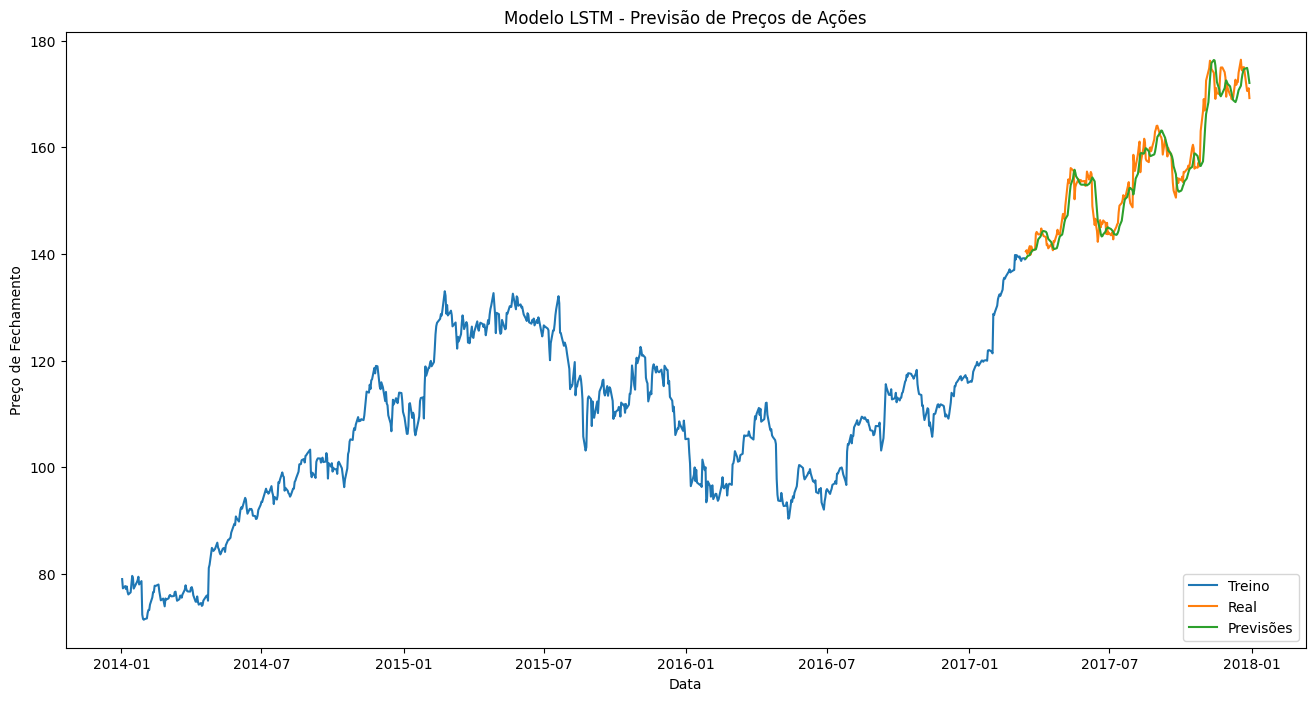

In [9]:
train = df_symbol[:train_size]
valid = df_symbol[train_size:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Modelo LSTM - Previsão de Preços de Ações')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.plot(train['date'], train['close'])
plt.plot(valid['date'], valid[['close', 'Predictions']])
plt.legend(['Treino', 'Real', 'Previsões'], loc='lower right')
plt.show()